# Supervised Learning Capstone Presentation

## Exploring Wage Disparities Across Occupations

In this notebook I will be exploring the Kaggle dataset of the US Bureau of Labor Statistics January 2015 report on income by gender and occupation. The dataset states that it shows 535 different occupations, and their corresponding weekly median incomes, broken down into men, women, and all, columns. Also included are reported numbers of emplyees for each occupation.

With this data, I would like to see if I can predict the occupational category of a job given input on wage, gender, share of females, gender ratio, wage gap, and if the field is male dominated or has a significant wage gap. 



### A few things to acknowledge before we get started. 

We are going to be using a few different modules for this experiment, including SKLearn heavily. Pandas, Numpy, and Seaborn are here as well. We will be measuring how well we are doing using the different models built in scoring mechanism and also sklearn.metrics accuracy_score, which measures your predicted labels compared to your correct labels. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

In [4]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"


Taking our first look at our data, it looks like the occupation categories are all upper case. That's going to make it easy for us to pull them out later. Those Nan values will dropped, and we'll change the dtypes to make sure everything that's a number isn't a string. 

In [5]:
genderwage = pd.read_csv(datafile)
genderwage.head()

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na


In [6]:
genderwage.count()

Occupation     558
All_workers    558
All_weekly     558
M_workers      558
M_weekly       558
F_workers      558
F_weekly       558
dtype: int64

In [7]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [8]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [9]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [10]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

In [11]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

categories_df = genderwage.loc[genderwage['Occupation'].isin(categories)].reset_index(drop=True).copy()


In [12]:
indices =[]
category_index = pd.Index(list(genderwage['Occupation']))
for i in categories:
    index = category_index.get_loc(i)
    indices.append(index)

In [13]:
genderwage.insert(1, 'Occupation_Category', 0)

In [14]:
cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    

In [15]:
genderwage.insert(1, 'Occupation_Category_label', 0)

In [16]:
cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

# Here i made a dataframe of the occupations that did NOT report anything for female weekly wages

Not really sure what good this will do, but maybe i could compare the occupational categories that did not report wages vs those that did?

In [18]:
no_wage_df = genderwage.where(genderwage['F_weekly'].isnull())


In [19]:
no_wage_df.isnull().sum()

Occupation                   192
Occupation_Category_label    192
Occupation_Category          192
All_workers                  192
All_weekly                   428
M_workers                    192
M_weekly                     468
F_workers                    192
F_weekly                     558
dtype: int64

In [20]:
no_wage_df = no_wage_df.dropna(axis=0, how='all')
no_wage_df.isnull().sum()

Occupation                     0
Occupation_Category_label      0
Occupation_Category            0
All_workers                    0
All_weekly                   236
M_workers                      0
M_weekly                     276
F_workers                      0
F_weekly                     366
dtype: int64

In [21]:
no_wage_df['GenderRatio'] = no_wage_df['F_workers'] / no_wage_df['M_workers']

In [22]:
no_wage_df.describe()

,Occupation_Category,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly,GenderRatio
count,366.000000,366.000000,130.000000,366.000000,90.000000,366.000000,0.0,359.000000
mean,14.688525,69.699454,953.753846,58.896175,979.266667,10.795082,NaN,inf
std,6.951198,128.537814,355.417258,124.705396,376.822874,12.813908,NaN,NaN
min,1.000000,0.000000,354.000000,0.000000,389.000000,0.000000,NaN,0.000000
25%,9.000000,11.000000,685.500000,7.000000,725.250000,1.000000,NaN,0.030769
50%,18.000000,30.000000,874.500000,20.000000,879.500000,5.000000,NaN,0.200000
75%,21.000000,67.000000,1152.500000,49.000000,1103.250000,17.000000,NaN,0.825758
max,22.000000,1181.000000,1952.000000,1155.000000,1892.000000,49.000000,NaN,inf


Setting up our cleaned dataframe, we drop all 'Nan' values, and also pluck out the occupation categories, then reset the index. The counts for occupational categories are quite low, which isn't surprising given the small size of this dataset, but we will still combine a few of them because the counts are simply too low. 

'Legal' will be rolled into 'Social Service', 'Healthcare Support' will be combined with 'Healthcare Professional'. 'Agriculture, 'Groundskeeping', Maintenance', and 'Construction' will all be rolled into 'Infrastructure Support'. 'Protective Service', 'Service', and 'Arts' will all be 'Other'.

In [23]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any').copy()
cleanedgenderwage = cleanedgenderwage.loc[~cleanedgenderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [24]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
PRODUCTION                 11
SALES                      11
HEALTHCARE PROFESSIONAL     7
CULINARY                    7
COMPUTATIONAL               7
TRANSPORTATION              4
EDUCATION                   4
PROTECTIVE SERVICE          3
ARTS                        3
SCIENCE                     3
SOCIAL SERVICE              3
SERVICE                     3
GROUNDSKEEPING              3
ENGINEERING                 2
AGRICULTURAL                1
HEALTHCARE SUPPORT          1
LEGAL                       1
Name: Occupation_Category_label, dtype: int64

To try to predict the occupation category, we're going to need to have categories that have more than a single instance in them. To solve this problem, we're going to combine a few of the different categories. Healthcare Support will be merged with Healthcare Professional, to become simply Healthcare. Agriculture, Construction, Maintenance and Groundskeeping will all be rolled in to Infrastructure Support. Engineering will be added to Science, and then Protective Service, Serviec, Arts, and Legal will all be put into Other.

In [25]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE PROFESSIONAL', 'Occupation_Category_label'] = 'HEALTHCARE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'CONSTRUCTION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'GROUNDSKEEPING', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ENGINEERING', 'Occupation_Category_label'] = 'SCIENCE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'PROTECTIVE SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ARTS', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'OTHER'


In [26]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
SALES                      11
PRODUCTION                 11
OTHER                       9
HEALTHCARE PROFESSIONAL     8
COMPUTATIONAL               7
CULINARY                    7
SCIENCE                     5
TRANSPORTATION              4
EDUCATION                   4
INFRASTRUCTURE SUPPORT      4
SOCIAL SERVICE              4
Name: Occupation_Category_label, dtype: int64

## Preliminary Data Exploration

Here we will take a look at the distributions male to female workers, male to female wages, and finally see a scatter plot of male to female wages.

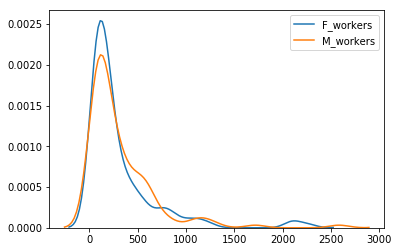

In [27]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.show()

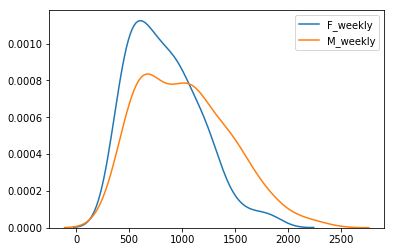

In [28]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.show()

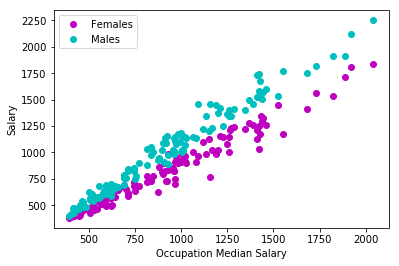

In [29]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.ylabel('Salary')
plt.show()

# Ook, well thats distinct. 

These distributions of wages indicate that the number of women earning between $500-1000/week is more than men, and that there are more men earning between $1500-2000/week. The scatter plot clearly shows the men's wages consistently plotting higher than the women's.

Next, lets take a look at the wages by occuaptional category. I'll mark the men with an x and the women with an o.

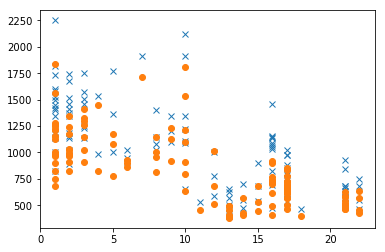

In [63]:
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['M_weekly'], 'x')
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['F_weekly'], 'o')
plt.show()

# Now lets create some features

Here what I've done is compared the womens income to mens income to get a ratio that shows what percentage of mens incomes women make.

Then we divided the female workforce by the male workforce to get our gender ratio. 

Then I made two complimentary columns of the mens and womens share of workers by dividing each by all workers.

In [31]:
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
cleanedgenderwage['GenderRatio'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['M_workers']
cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']
cleanedgenderwage['M_share'] = cleanedgenderwage['M_workers'] / cleanedgenderwage['All_workers']

## Next I marked which occupations are male dominated

Any ratio under .85 is considered male dominated as that shows a 15% or more majority over women.

# I also made a column marking occupations with significant wage gaps

For our purposes, I decided that a significant wage gap is a difference of 15% or more over women.

In [32]:
def male_dom(x):
    if x > .85:
        return 0
    return 1

cleanedgenderwage['Male_Dominated'] = cleanedgenderwage['GenderRatio'].apply(male_dom)


In [33]:

cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

In [34]:
# same features, just in the categories dataframe
# Dont' know if i need this cell

categories_df[['All_weekly',
            'M_weekly',
            'F_weekly']] = categories_df[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

categories_df['WageRatio'] = categories_df['F_weekly'] / categories_df['M_weekly']
categories_df['GenderRatio'] = categories_df['F_workers'] / categories_df['M_workers']
categories_df['WageGap'] = categories_df['M_weekly'] - categories_df['F_weekly']
categories_df['F_share'] = categories_df['F_workers'] / categories_df['All_workers']
categories_df['M_share'] = categories_df['M_workers'] / categories_df['All_workers']
categories_df['All_Workers_Difference'] = categories_df['All_workers'] - (categories_df['M_workers'] + categories_df['F_workers'])




## Lets plot some of these new features

We'll look at a distribution plot of the wage gap, bar plots of weekly income by occupation, wage gap by occupation, gender ratio by occupation, wage ratio by occupation, and a scatter plot of mens weekly income and womens weekly income as a function of the reported occupation median income, color coded to each occupation.

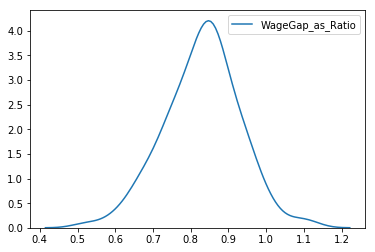

In [69]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])
plt.show()

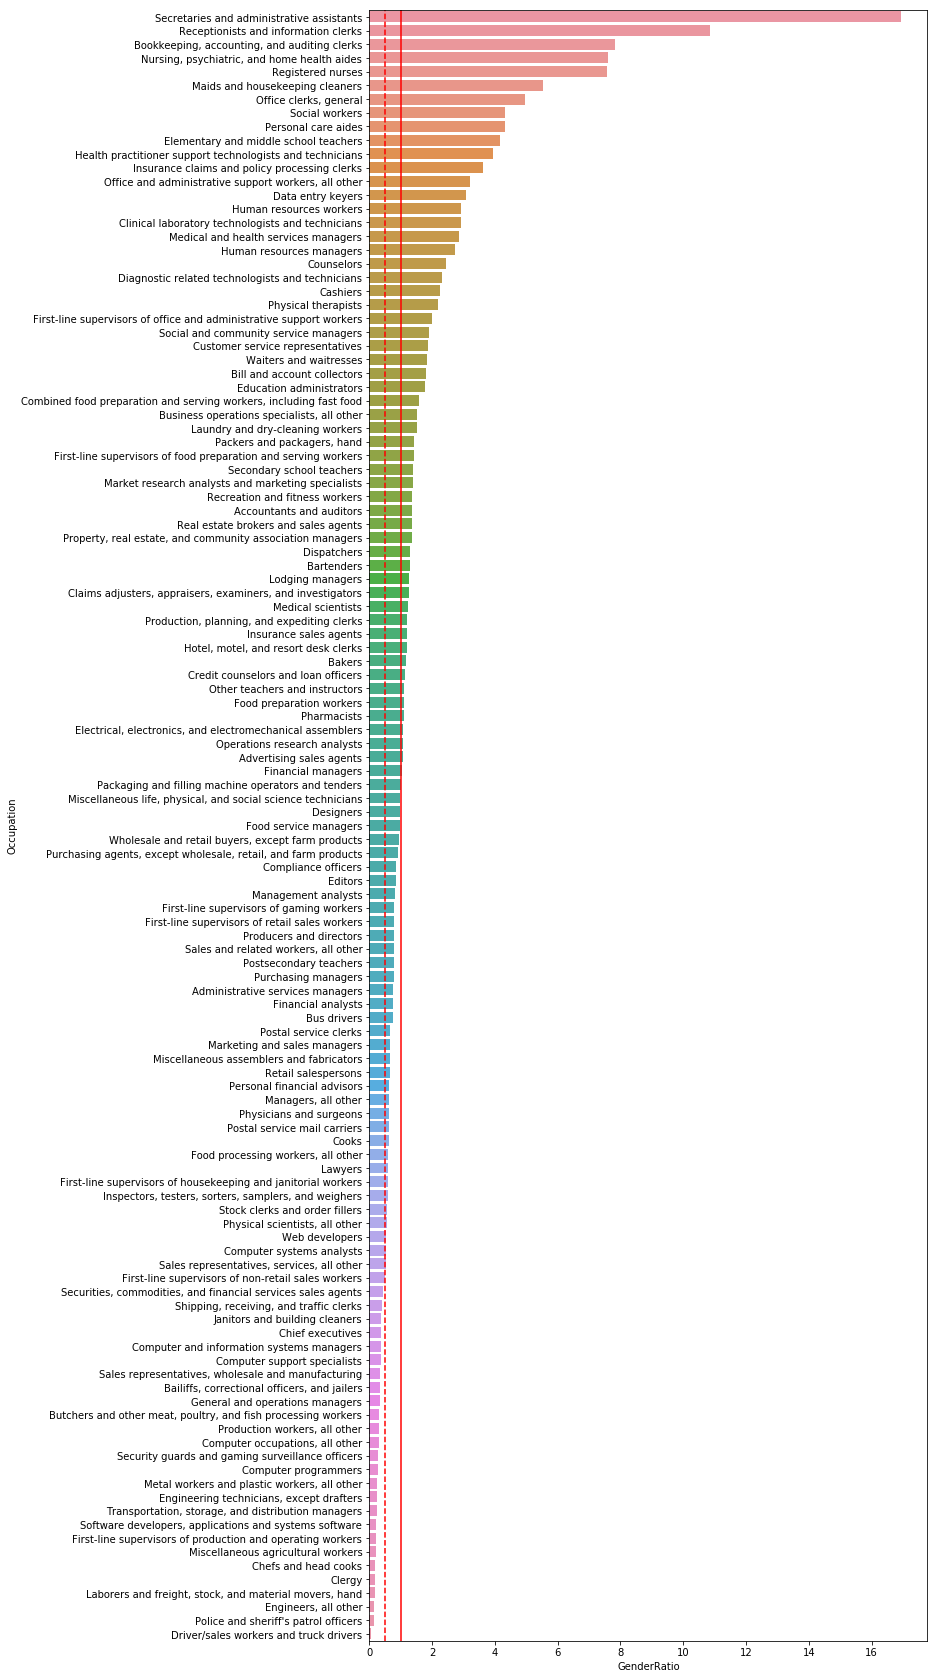

In [36]:

# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='GenderRatio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('GenderRatio', ascending=False))
plt.axvline(x=1, color='red', linestyle='solid')
plt.axvline(x=.5, color='red', linestyle='--')
plt.show()

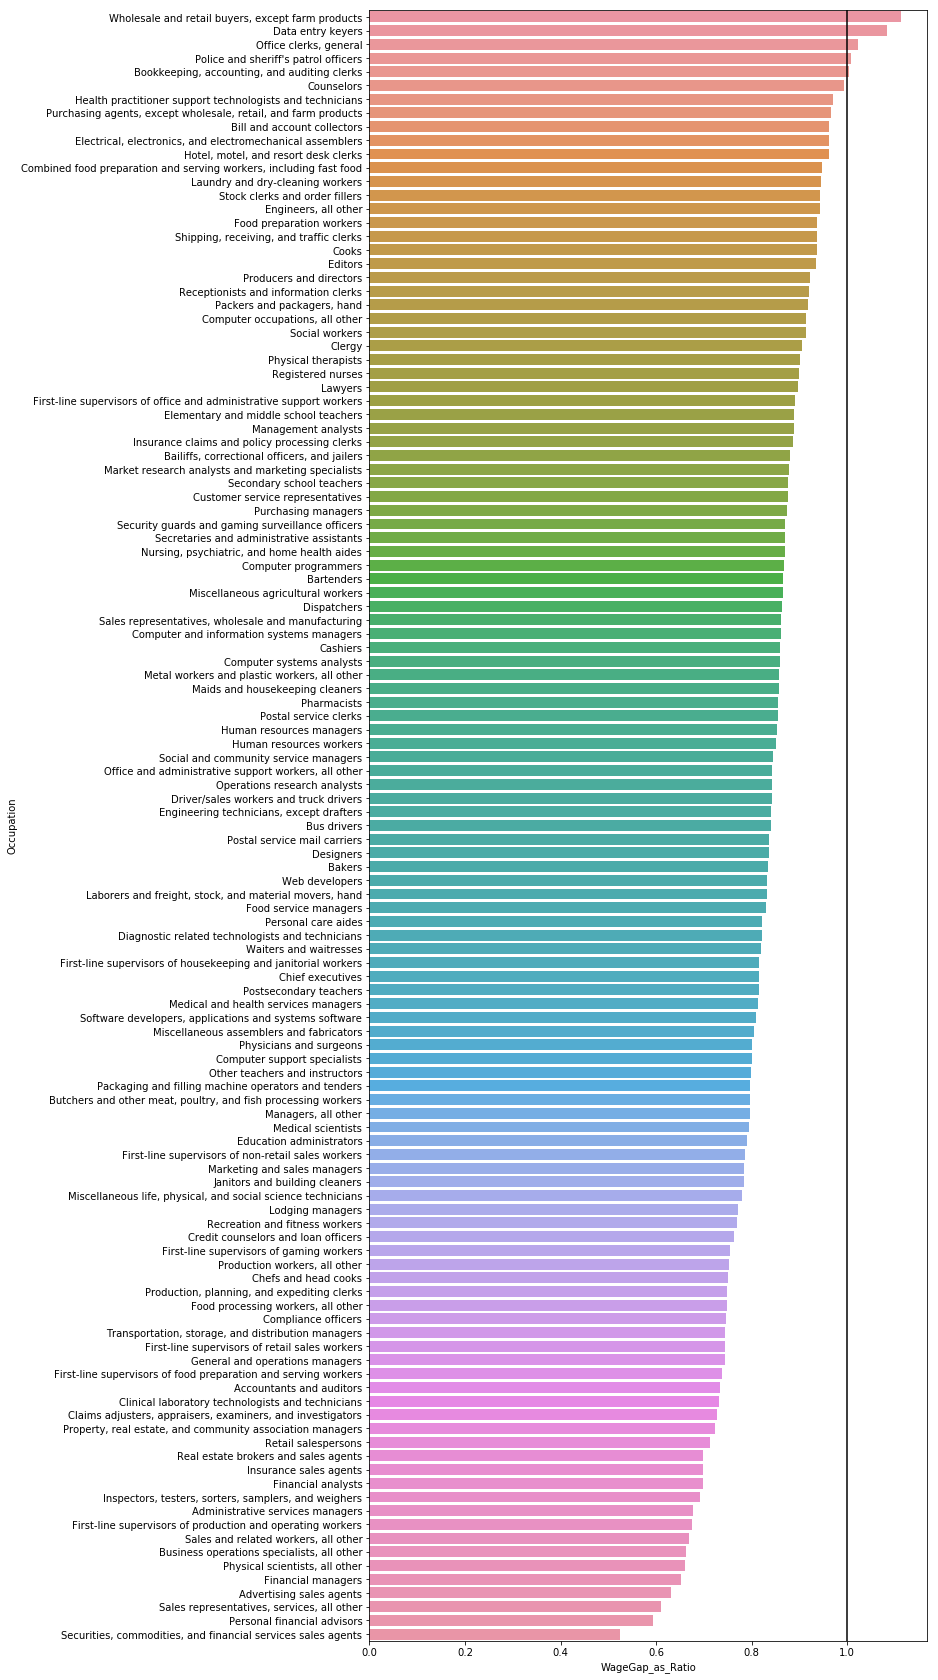

In [70]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio', ascending=False))
plt.axvline(x=1, color='black', linestyle='solid')
plt.show()

# Lets take a look at some lm plots to see if there is a relationship between income and gender ratios

#  Make these 4 subplots not 4 plots in a row

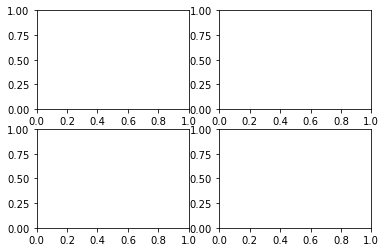

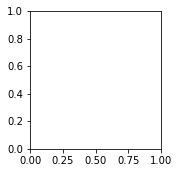

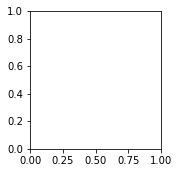

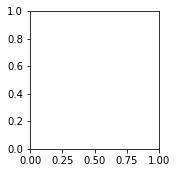

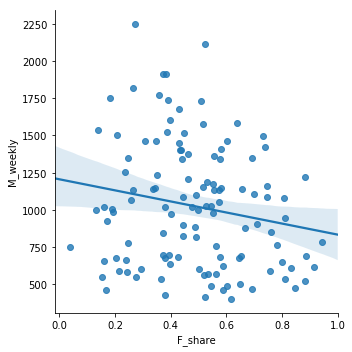

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2)

plt.subplot(2, 2, 1)
sns.lmplot(x='M_share', y='F_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 2)
sns.lmplot(x='M_share', y='M_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 3)
sns.lmplot(x='F_share', y='F_weekly', data=cleanedgenderwage)

plt.subplot(2, 2, 4)
sns.lmplot(x='F_share', y='M_weekly', data=cleanedgenderwage)

plt.show()

# Lets look at a bigger scatter plot of m/f incomes, and color it according to occupation

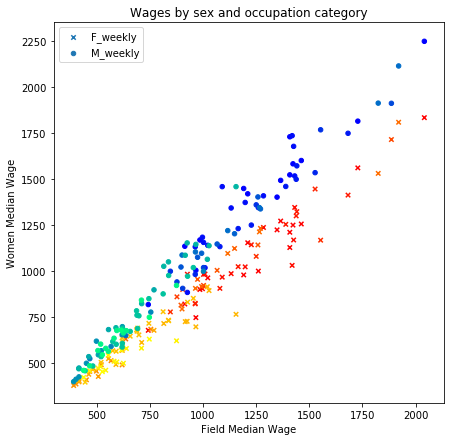

In [39]:
# plot wage by gender and color by occupation category
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title("Wages by sex and occupation category")
ax.set_xlabel("Field Median Wage")
ax.set_ylabel("Women Median Wage")
x = cleanedgenderwage['All_weekly']
y = cleanedgenderwage['F_weekly']
y2 = cleanedgenderwage['M_weekly']
colors = [str(item) for item in cleanedgenderwage['Occupation_Category']]

ax.scatter(x, y, s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'x', cmap=plt.cm.autumn);
ax.scatter(x, y2 ,s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'o', cmap=plt.cm.winter);
plt.legend()
plt.show()


# Time for some MODELS

we will be reviewing linear or logisitic regression classifier, then lasso regression classifier, then a random forest classifier

The questions I will be looking to answer today is:
     - Can you predict the occupational category given wage, gender, gender ratio and share of females for that field, if that field is male dominated or not, and if that feild has a significant wage gap? 

If we are able to accurately predict the occuational category using a given wage, gender, or share of females, then perhaps there is some other underlying structure influencing wages.

In [40]:
# make new dfs here
F_df = pd.DataFrame()
M_df = pd.DataFrame()

# make category variable for gender
F_df['Wage'] = cleanedgenderwage['F_weekly']
M_df['Wage'] = cleanedgenderwage['M_weekly']

F_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']
M_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']

F_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']
M_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']

F_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']
M_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']

F_df['Gender'] = np.ones(len(cleanedgenderwage))
M_df['Gender'] = np.zeros(len(cleanedgenderwage))

F_df['F_share'] = cleanedgenderwage['F_share']
M_df['F_share'] = cleanedgenderwage['F_share']
F_df['GenderRatio'] = cleanedgenderwage['GenderRatio']
M_df['GenderRatio'] = cleanedgenderwage['GenderRatio']

F_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']
M_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']


F_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']
M_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']

combined_df = F_df.append(M_df)



# Lets make a function to test our models,

In [41]:
# set up training and testing sets, fit model, score model
# need to split up dataset before oversampling



def model_testing(model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scored_model_train = model.score(X_train, y_train)
    scored_model_test = model.score(X_test, y_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    print("Model Score with Training data:")
    print(scored_model_train)
    print("Model Score with Testing data:")
    print(scored_model_test)
    print("Accuracy Score")
    print(model_accuracy)
   

In [42]:
def sampled_set(data, sample_count):
    sampled = np.random.choice(a=data, size=sample_count)
    return(sampled)


In [43]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k=3, ratio=1, kind='regular')

Next steps are to scale our data, split it up and resample our training data, then test our models.

In [68]:
# scale columns here
scaler = StandardScaler()
columns = ['Wage',
           'Male_Dominated',
           'Significant_wage_gap',
           'WageGap_as_Ratio',
           'Gender',
           'F_share', 
           'GenderRatio']

# split up data first, then resample only the training data, maybe try smote again
X = combined_df[columns]

X_std = StandardScaler().fit_transform(X)
y = combined_df['Occupation_Category']

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.35)

# Lets do some bootstrapping for our resample
X_train_resam = sampled_set(X_train, 500)
y_train_resam = sampled_set(y_train, 500)

ValueError: a must be 1-dimensional

In [67]:
len(y_train)

154

In [46]:
# Linear/logisitic Regression here
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
model_testing(logr, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.37012987012987014
Model Score with Testing data:
0.4523809523809524
Accuracy Score
0.4523809523809524


In [47]:
# Lasso Regression classifier here
lasso = linear_model.Lasso()
#model_testing(lasso, X_std, y, .35)

In [48]:
# Ridge Regression classifier here
ridge = linear_model.RidgeClassifier()
model_testing(ridge, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.36363636363636365
Model Score with Testing data:
0.3333333333333333
Accuracy Score
0.3333333333333333


In [49]:
# Random Forest Classifier here
forest = ensemble.RandomForestClassifier(n_estimators=300, max_depth=3)
model_testing(forest, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.6103896103896104
Model Score with Testing data:
0.38095238095238093
Accuracy Score
0.38095238095238093


In [50]:
# SVM?
from sklearn.svm import SVC
svc = SVC()
model_testing(svc, X_test, y_test, X_train, y_train)

Model Score with Training data:
0.44155844155844154
Model Score with Testing data:
0.27380952380952384
Accuracy Score
0.27380952380952384


In [51]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
model_testing(dtree, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.5952380952380952
Accuracy Score
0.5952380952380952


In [52]:
extree = ensemble.ExtraTreesClassifier()
model_testing(extree, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.6309523809523809
Accuracy Score
0.6309523809523809


In [53]:
gradient = ensemble.GradientBoostingClassifier()
model_testing(gradient, X_test, y_test, X_train, y_train)

Model Score with Training data:
1.0
Model Score with Testing data:
0.6190476190476191
Accuracy Score
0.6190476190476191


The tpp three preliminary models were the decision tree classifier, the extra trees classifier and the gradient boosting classifier. 

Next we will use SKLearn's built in tool GrilSearch to find the best hyperparameters.

In [54]:
# Put hyper parameter adjustment here
from sklearn.model_selection import GridSearchCV

extra_tree_param = {'criterion': ('gini', 'entropy'),
                    'max_depth': (2, 3, 5),
                    'n_estimators': (10, 50, 100)}
decision_tree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_params = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 150, 200),
                   'max_depth':(2, 3, 4, 5, 6)}

def check_grid(estimator, params):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X_std, y)
    grid_score = grid_classifier.score(X_std, y)
    print(grid_score)

In [55]:
check_grid(dtree, decision_tree_param)

0.6554621848739496


In [56]:
check_grid(extree, extra_tree_param)

0.7857142857142857


In [57]:
check_grid(gradient, gradient_params)

1.0


In [58]:
# get params here for best model

In [62]:
# Put model validation here

# Put conclusion here